In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error


In [22]:
# Read csv file
df = pd.read_csv("cleaned_data.csv")  
df = df.drop(columns=["url", "id"]) # drop columns url, id
df = df.drop(columns=["MunicipalityCleanName", "locality"]) # same variable as post code
df = df.drop(columns=["type", "postCode", "hasGarden", "region", "price_square_meter"])
# Convert 'postCode' to string
# df['postCode'] = df['postCode'].astype(str)
df.columns

Index(['subtype', 'bedroomCount', 'province', 'habitableSurface',
       'buildingCondition', 'gardenSurface', 'hasTerrace', 'epcScore', 'price',
       'hasParking'],
      dtype='object')

In [23]:
# copy the original dataFrame to evoid overwritting
df_clean = df.copy()

# Identify unique numerical columns
numeric_cols = df_clean.select_dtypes(include=["float64", "int64"]).columns

# Delete outliers in each numerical column
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

# Display the form of cleaning DataFrame
print(f"Remaining observations : {df_clean.shape[0]} (on {df.shape[0]})")

Remaining observations : 28802 (on 41726)


In [24]:
# rename the dataFrame
df = df_clean

In [25]:
# convert feature epcScore and buildingConstruction to numerical
epc_score = {"A++": 9,
             "A+": 8,
             "A": 7,
             "B": 6,
             "C": 5,
             "D": 4,
             "E": 3,
             "F": 2,
             "G": 1}
df["epc_score"] = df["epcScore"].map(epc_score)

building_condition = {"AS_NEW": 6,
                      "GOOD": 5,
                      "JUST_RENOVATED": 4,
                      "TO_BE_DONE_UP": 3,
                      "TO_RENOVATE": 2,
                      "TO_RESTORE": 1}
df["building_condition"] = df["buildingCondition"].map(building_condition)


In [26]:
# list of nominal variable

cat_features = ['subtype', 'province']

# ColumnTransformer with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'  # others numerical columns still unchange
)

In [ ]:

# Complet Pipeline for linear regression
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regression', LinearRegression())
])

y = df["price"]
# drop buildingCondition and epcScore after convertion 
X = df.drop(columns=["price", "buildingCondition", "epcScore"])
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# Training of the model
model.fit(X_train, y_train)

# Predictions
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Display prediction
#print("Prédictions :", y_pred)

r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("R² on test :", r2_test)
print("R² on train :", r2_train)
print("MAE on test :", mae_test)
print("MAE on train:", mae_train)

Index(['subtype', 'bedroomCount', 'province', 'habitableSurface',
       'gardenSurface', 'hasTerrace', 'hasParking', 'epc_score',
       'building_condition'],
      dtype='object')
R² on test : 0.5398185092606643
R² on train : 0.5298485646238154
MAE on test : 68738.79391879347
MAE on train: 68908.54036259574


c:\Users\augka\Desktop\becode\BXL-Bouman-9\projects\02-TheHill\Immo_Eliza_Regression\monenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Pipeline with Random Forest
model_rf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regression', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Training of the model
model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf_test = model_rf.predict(X_test)
y_pred_rf_train = model_rf.predict(X_train)

# Simple assessment
r2_test = r2_score(y_test, y_pred_rf_test)
r2_train = r2_score(y_train, y_pred_rf_train)

mae_test = mean_absolute_error(y_test, y_pred_rf_test)
mae_train = mean_absolute_error(y_train, y_pred_rf_train)

print("R² of Random Forest model on test :", r2_test)
print("R² of Random Forest model on train :", r2_train)
print("MAE of Random Forest model on test :", mae_test)
print("MAE of Random Forest model on train :", mae_train)

c:\Users\augka\Desktop\becode\BXL-Bouman-9\projects\02-TheHill\Immo_Eliza_Regression\monenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R² of Random Forest model on test : 0.5597988939258828
R² of Random Forest model on train : 0.9131205349246132
MAE of Random Forest model on test : 64903.79312799255
MAE of Random Forest model on train : 27295.16156898635


In [39]:
# comparison between prediction and real value
comparison = pd.DataFrame({
    "Real Values": y_train.values,
    "Prediction": y_pred_train
})
#print(comparison.head(10))

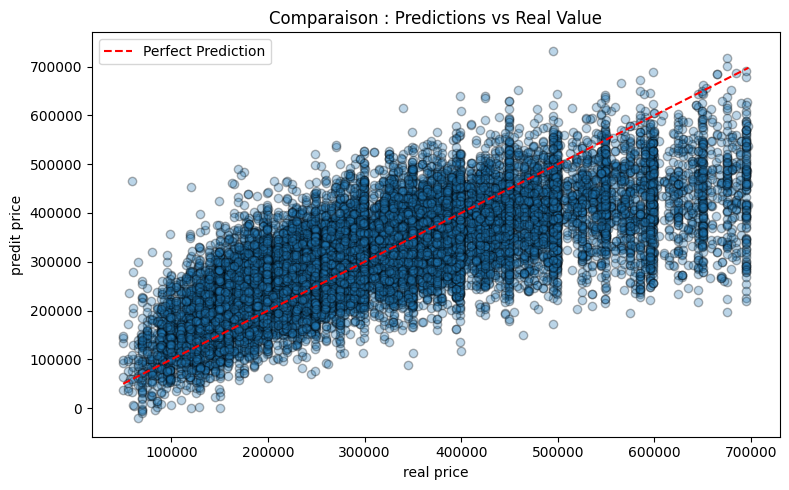

In [45]:
# scatterplot of the comparison
plt.figure(figsize=(8, 5))
plt.scatter(y_train, y_pred_train, alpha=0.3, edgecolors='k')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("real price")
plt.ylabel("predit price")
plt.title("Comparaison : Predictions vs Real Value")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# search of anomalie
df_resultats = pd.DataFrame({
    "real_price": y_train,
    "predit_price": y_pred_train,
})
df_resultats["error"] = df_resultats["real_price"] - df_resultats["predit_price"]
df_resultats["absolute_error"] = df_resultats["error"].abs()


In [42]:
anomalies = df_resultats.sort_values(by="absolute_error", ascending=False).head(10)
print(anomalies)


       real_price   predit_price          error  absolute_error
31092    675000.0  196625.170729  478374.829271   478374.829271
7026     695000.0  218689.571033  476310.428967   476310.428967
34178    695000.0  224864.701325  470135.298675   470135.298675
34682    695000.0  240957.878260  454042.121740   454042.121740
5481     675000.0  222744.595243  452255.404757   452255.404757
4800     695000.0  255261.070321  439738.929679   439738.929679
34222    645000.0  216734.921072  428265.078928   428265.078928
34541    695000.0  269706.989045  425293.010955   425293.010955
34162    695000.0  278197.232734  416802.767266   416802.767266
34159    675000.0  258615.234251  416384.765749   416384.765749


In [43]:
# Join with X_test to see caracteristics 
anomalies = anomalies.join(X_train, how="left")

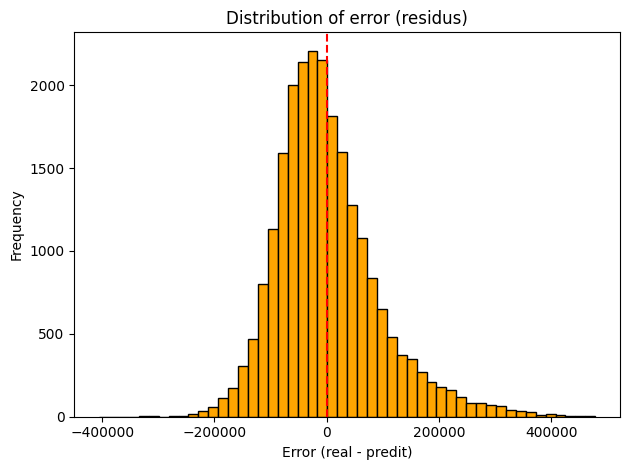

In [44]:
# histogramm of error distribution
plt.hist(df_resultats["error"], bins=50, color="orange", edgecolor="black")
plt.title("Distribution of error (residus)")
plt.xlabel("Error (real - predit)")
plt.ylabel("Frequency")
plt.axvline(0, color="red", linestyle="--")
plt.tight_layout()
plt.show()

In [46]:
# Pipeline polynomial with degre 2
poly_model = make_pipeline(
    preprocessor,  # existing encoding
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

# Training
poly_model.fit(X_train, y_train)
y_pred_poly_test = poly_model.predict(X_test)
y_pred_poly_train = poly_model.predict(X_train)

# Assessment
r2_poly_test = r2_score(y_test, y_pred_poly_test)
r2_poly_train = r2_score(y_train, y_pred_poly_train)
# rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
mae_test = mean_absolute_error(y_test, y_pred_poly_test)
mae_train = mean_absolute_error(y_train, y_pred_poly_train)

print("R² of polynomial model on test :", r2_poly_test)
print("R² of polynomial model on train :", r2_poly_train)
print("MAE of polynomial model on test :", mae_test)
print("MAE of polynomial model on train :", mae_train)

#print("RMSE (polynomial) :", rmse_poly)

R² of polynomial model on test : 0.5863437898916182
R² of polynomial model on train : 0.5772835849667481
MAE of polynomial model on test : 64618.47339174661
MAE of polynomial model on train : 64807.26468096771


c:\Users\augka\Desktop\becode\BXL-Bouman-9\projects\02-TheHill\Immo_Eliza_Regression\monenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


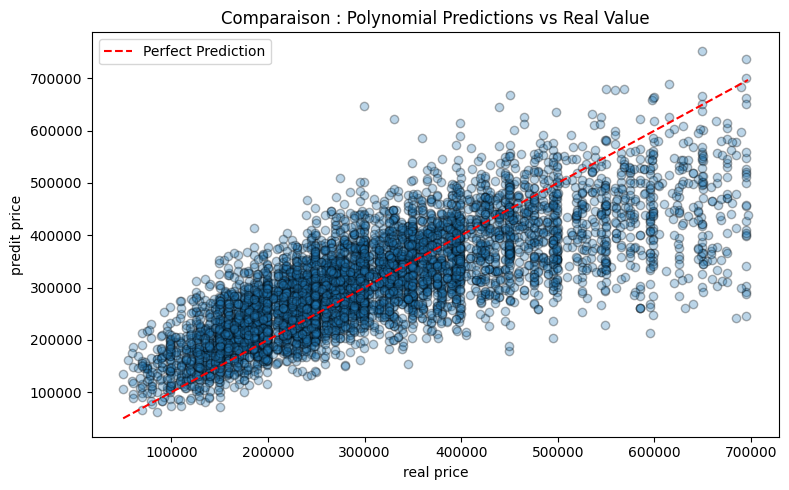

In [47]:
# comparison between prediction and real value
comparison = pd.DataFrame({
    "Real Values": y_test.values,
    "Prediction": y_pred_poly_test
})

# scatterplot of the comparison
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_poly_test, alpha=0.3, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("real price")
plt.ylabel("predit price")
plt.title("Comparaison : Polynomial Predictions vs Real Value")
plt.legend()
plt.tight_layout()
plt.show()

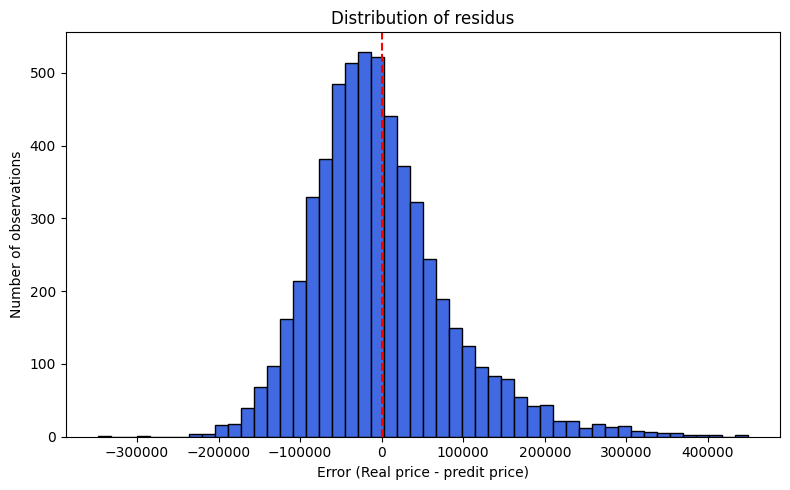

In [48]:
# Distribution of residus in polynomial model
residus = y_test - y_pred_poly_test

plt.figure(figsize=(8, 5))
plt.hist(residus, bins=50, color='royalblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of residus")
plt.xlabel("Error (Real price - predit price)")
plt.ylabel("Number of observations")
plt.tight_layout()
plt.show()

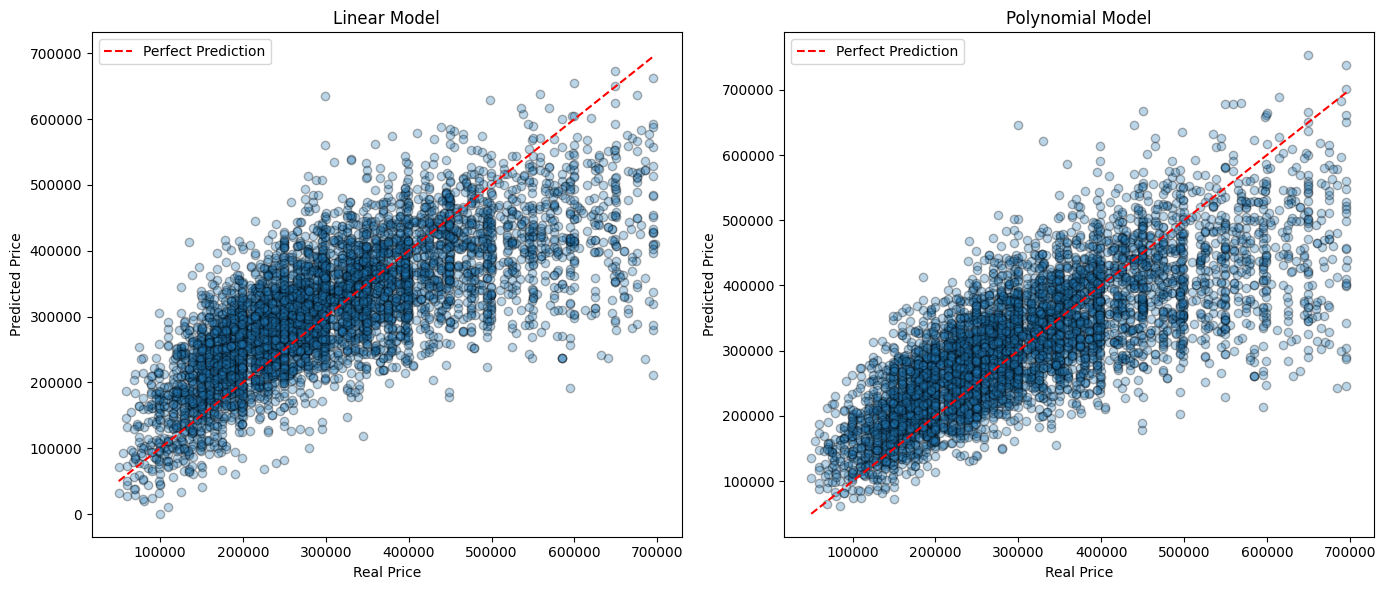

In [ ]:
# Initialization of two side-by-side subplots

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1st graph — Linear Model (left)
axes[0].scatter(y_test, y_pred_test, alpha=0.3, edgecolors='k')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', label='Perfect Prediction')
axes[0].set_xlabel("Real Price")
axes[0].set_ylabel("Predicted Price")
axes[0].set_title("Linear Model")
axes[0].legend()

# 2nd graph — Polynomial Model (right)
axes[1].scatter(y_test, y_pred_poly_test, alpha=0.3, edgecolors='k')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', label='Perfect Prediction')
axes[1].set_xlabel("Real Price")
axes[1].set_ylabel("Predicted Price")
axes[1].set_title("Polynomial Model")
axes[1].legend()

plt.tight_layout()
plt.show()

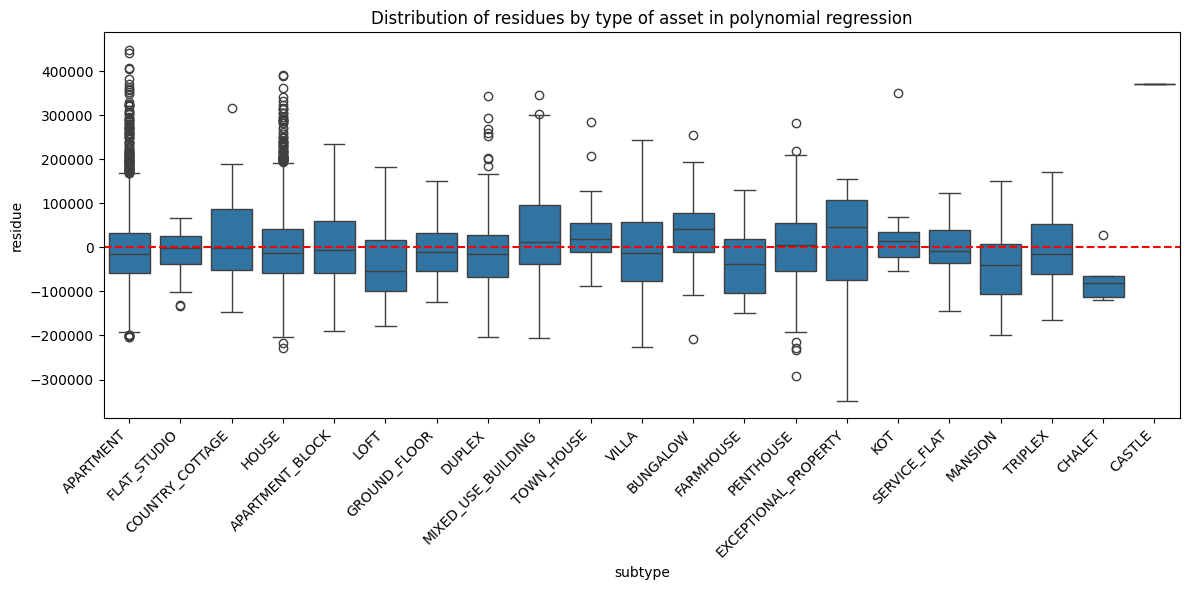

In [53]:
# Create the residuals column 
residus = y_test - y_pred_poly_test
df_residus = pd.DataFrame({
    "subtype": X_test["subtype"],  # Raw column (not encoded)
    "residue": residus
})

# We group all the present subtypes
plt.figure(figsize=(12, 6))
sns.boxplot(x="subtype", y="residue", data=df_residus)
plt.axhline(0, color="red", linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of residues by type of asset in polynomial regression")
plt.tight_layout()
plt.show()

In [51]:
# Log-transformer target
y_train_log = np.log1p(y_train)  # log(1 + y)
y_test_log = np.log1p(y_test)

# Pipeline regression log
log_model = make_pipeline(
    preprocessor,
    LinearRegression()
)

log_model.fit(X_train, y_train_log)
y_pred_log = log_model.predict(X_test)

# Reverse the transformation
y_pred_log_exp = np.expm1(y_pred_log)

# Assessment
#rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log_exp))
r2_log = r2_score(y_test, y_pred_log_exp)
mae = mean_absolute_error(y_test, y_pred_log_exp)

print("R² of log model :", r2_log)
print("MAE of log model :", mae)
#print("RMSE of log model :", rmse_log)

R² of log model : 0.5188163546042697
MAE of log model : 67936.41428592372


c:\Users\augka\Desktop\becode\BXL-Bouman-9\projects\02-TheHill\Immo_Eliza_Regression\monenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
